In [1]:
from google.colab import files
files.upload()


!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dima87/madecvhw1
!unzip -q *.zip 
!rm madecvhw1.zip
!rm -r sample_data

! mv test_points.csv data/data/test/

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 68 May 12 18:55 kaggle.json
100% 12.6G/12.6G [05:06<00:00, 28.8MB/s]
100% 12.6G/12.6G [05:06<00:00, 44.2MB/s]


In [2]:
import glob
import os
import pickle

import PIL
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models as models
from PIL import Image
from torch import nn
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms
from tqdm.notebook import tqdm

%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(1234)
torch.manual_seed(1234)

TRAIN_SIZE = 0.8
NUM_PTS = 971
CROP_SIZE = 128
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

LEN_DF = 393930
CHUNK_SIZE = 50000

DATA_ROOT = 'data/data/'

NUM_PTS = 971
LR = 1e-3

MAX_EPOCHS_NUM = 10

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        self.size = torch.tensor(size, dtype=torch.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample


class ThousandLandmarksDataset(data.Dataset):

    def __init__(self, root, transforms, split="train"):
        super(ThousandLandmarksDataset, self).__init__()
        self.root = root
        landmark_file_name = os.path.join(root, 'landmarks.csv') if split is not "test" \
            else os.path.join(root, "test_points.csv")
        images_root = os.path.join(root, "images")

        # 393930 the number of rows in the training dataset
        # change to a smaller number if you need to learn from a piece of data
        n_rows = LEN_DF if split is not "test" else None
        print(f"Cook {split} data from csv...")

        df_chunk = pd.read_csv(landmark_file_name, nrows=n_rows, chunksize=CHUNK_SIZE, delimiter='\t', )
        self.landmarks = []
        self.image_names = []

        print(f"Chunk...", end=' ')
        for i, chunk in enumerate(df_chunk):
            split_idxs = {"train": range(0, int(TRAIN_SIZE * len(chunk))),
                          "val": range(int(TRAIN_SIZE * len(chunk)), len(chunk)),
                          "test": range(len(chunk))}
            idxs = split_idxs[split]

            print(f'{i}...', end=' ')
            if split in ("train", "val"):
                for row in chunk._values[idxs]:
                    self.image_names.append(os.path.join(images_root, row[0]))
                    self.landmarks.append(row[1:].astype('int32').reshape((len(row) // 2, 2)))
            elif split == 'test':
                for row in chunk._values[idxs]:
                    self.image_names.append(os.path.join(images_root, row[0]))
                self.landmarks = None
            else:
                raise NotImplementedError(split)
        print(f'finish')

        print('Convert to tensor...', end=' ')
        if split in ("train", "val"):
            self.landmarks = torch.as_tensor(self.landmarks)
        elif split == 'test':
            self.landmarks = None
        else:
            raise NotImplementedError(split)

        self.transforms = transforms
        print('finish')

    def __getitem__(self, idx):
        sample = {}
        if self.landmarks is not None:
            landmarks = self.landmarks[idx]
            sample["landmarks"] = landmarks

        image = cv2.imread(self.image_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.image_names)


def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks


def restore_landmarks_batch(landmarks, fs, margins_x, margins_y):
    landmarks[:, :, 0] += margins_x[:, None]
    landmarks[:, :, 1] += margins_y[:, None]
    landmarks /= fs[:, None, None]
    return landmarks


def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data, "test")

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [0]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions


In [6]:
train_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
    ])

train_dataset = ThousandLandmarksDataset(
    root=f'{DATA_ROOT}train',
    transforms=train_transforms, 
    split="train")

val_dataset = ThousandLandmarksDataset(
    root=f'{DATA_ROOT}train',
    transforms=train_transforms, 
    split="val")

test_dataset = ThousandLandmarksDataset(
    root=f'{DATA_ROOT}test',
    transforms=train_transforms,
    split="test")




Cook train data from csv...
Chunk... 0... finish
Convert to tensor... finish
Cook val data from csv...
Chunk... 0... finish
Convert to tensor... finish
Cook test data from csv...
Chunk... 0... 1... 2... 3... 4... 5... 6... 7... 8... 9... finish
Convert to tensor... finish


In [0]:
models_set = {
    'resnet152': {'model': models.resnet152(pretrained=True), 'batch_size': 256},
    'resnet18': {'model': models.resnet18(pretrained=True), 'batch_size': 512},
    'resnet50': {'model': models.resnet50(pretrained=True), 'batch_size': 256}
}

In [11]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")

for name, param in models_set.items():

    batch_size = param['batch_size']
    model = param['model']
    model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
    model = model.to(device)

    print(f'TRAIN {name.upper()}')

    train_dataloader = data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        num_workers=4, 
        pin_memory=True,
        shuffle=True, 
        drop_last=True)

    val_dataloader = data.DataLoader(
        val_dataset, 
        batch_size=batch_size,
        num_workers=4, 
        pin_memory=True,
        shuffle=False, 
        drop_last=False)
    
    test_dataloader = data.DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        num_workers=4,
        pin_memory=True,
        shuffle=False, 
        drop_last=False)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, amsgrad=True)
    loss_fn = fnn.mse_loss
    
    best_val_loss = np.inf

    for epoch in range(MAX_EPOCHS_NUM):
        train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
        val_loss = validate(model, val_dataloader, loss_fn, device=device)
        print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(f"{name}_best.pth", "wb") as fp:
                torch.save(model.state_dict(), fp)
        else:
            break

    with open(f"{name}_best.pth", "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        model.load_state_dict(best_state_dict)
    
    model.eval()

    test_predictions = predict(model, test_dataloader, device)

    with open(f"{name}_test_predictions.pkl", "wb") as fp:
        pickle.dump({
            "image_names": test_dataset.image_names,
            "landmarks": test_predictions}, fp)

    create_submission(DATA_ROOT, test_predictions, f"{name}_submit.csv")

    del model 
    torch.cuda.empty_cache()

TRAIN RESNET152



Epoch # 0:	train loss: 2.1e+03	val loss: 4.4e+02



Epoch # 1:	train loss: 1.5e+02	val loss: 5.1e+01



Epoch # 2:	train loss: 4.5e+01	val loss: 4.3e+01



Epoch # 3:	train loss: 4.2e+01	val loss: 4.2e+01



Epoch # 4:	train loss: 4.2e+01	val loss: 4.4e+01



TRAIN RESNET18



Epoch # 0:	train loss: 3.9e+03	val loss: 2.8e+03



Epoch # 1:	train loss: 2.8e+03	val loss: 1.6e+03



Epoch # 2:	train loss: 1.9e+03	val loss: 1e+03



Epoch # 3:	train loss: 1.2e+03	val loss: 6.9e+02



Epoch # 4:	train loss: 7.5e+02	val loss: 4.3e+02



Epoch # 5:	train loss: 4.4e+02	val loss: 2.7e+02



Epoch # 6:	train loss: 2.6e+02	val loss: 1.6e+02



Epoch # 7:	train loss: 1.5e+02	val loss: 1e+02



Epoch # 8:	train loss: 9.8e+01	val loss: 7.3e+01



Epoch # 9:	train loss: 7e+01	val loss: 5.9e+01



TRAIN RESNET50



Epoch # 0:	train loss: 2.2e+03	val loss: 5.6e+02



Epoch # 1:	train loss: 1.6e+02	val loss: 5.5e+01



Epoch # 2:	train loss: 4.6e+01	val loss: 4.2e+01



Epoch # 3:	train loss: 4.2e+01	val loss: 4.3e+01


In [0]:
submissions = {}

for name in models_set:
    submissions[name] = pd.read_csv(f"{name}_submit.csv", index_col='file_name')


mean_submission = ((5*submissions['resnet50'] + 3*submissions['resnet152'] + submissions['resnet18']) / 9).round().astype(int)

mean_submission.to_csv('_3mean.csv')


## Визулизация результатов

In [16]:
name = 'resnet152'
 
with open(f"{name}_test_predictions.pkl", "rb") as fp:  
    results = pickle.load(fp)

image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)


Images: 99819
Landmarks shape: (99819, 971, 2)


In [0]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

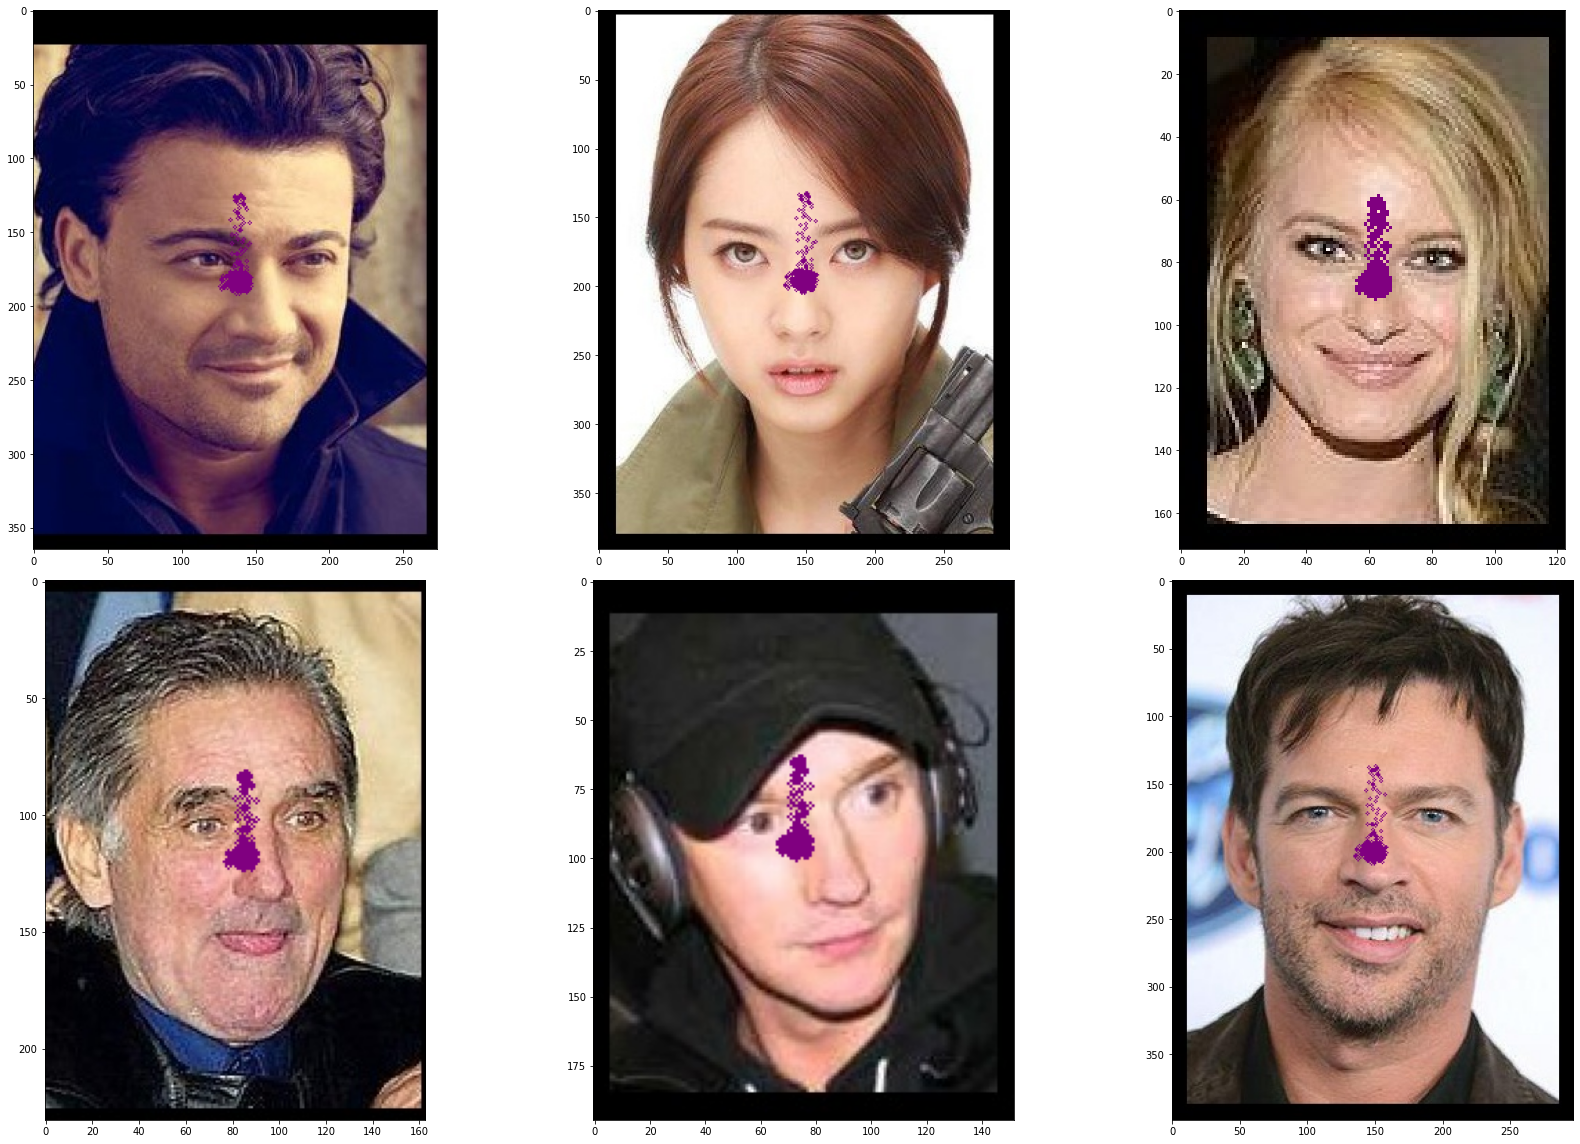

In [17]:
NUM_IMAGES_TO_SHOW = 6
NUM_COLS = 3
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)


random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()